<a href="https://colab.research.google.com/github/shrestha-bikash/Mood-Detection/blob/main/Mood_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! unzip mma_facial_dataset.zip

In [ ]:
import os

def create_list(path, filename, selection_num):
    fw = open(filename, 'w')

    for dirpath, dirnames, filenames in os.walk(path):
        if dirpath is not path:
            dir_name = dirpath.split('/')[-1]

            if dir_name in ['neutral', 'angry', 'happy', 'sad']:

                for f in filenames[:selection_num]:
                    # print(dirpath + '/' + f)
                    fw.write(dirpath + '/' + f + '\n')
    fw.close()

path_test = 'test'
path_train = 'train'
create_list(path_train, 'train_list.txt', 2500)
create_list(path_test, 'test_list.txt', 500)

In [ ]:
from PIL import  Image
from keras.preprocessing import image
import numpy as np

img = image.load_img('train/angry/Training_89270955.jpg')

img_np = np.array(img)

print(img_np.shape)


(48, 48, 3)


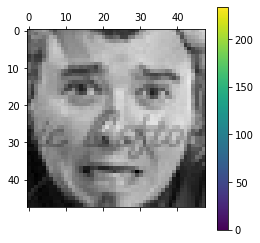

In [ ]:
import matplotlib.pyplot as plt

plt.matshow(img_np)
plt.colorbar()
plt.show()

In [ ]:
def get_list(path):
    f = open(path, 'r')
    flines = f.readlines()
    f.close()

    file_list = []

    for line in flines:
        file_name = line.split()[0]
        file_list.append(file_name)
    
    return file_list

def load_image(path):
    img = image.load_img(path)
    img_data = np.array(img)

    return img_data

def one_hot_encoding(class_labels, y_label):
    y_class = np.zeros(len(class_labels), dtype=int)
    class_index = class_labels.index(y_label)

    y_class[class_index] = 1

    return y_class

def get_input_output(path, batch_list, class_labels):
    X = np.zeros((len(batch_list), 48, 48, 3))
    Y = np.zeros((len(batch_list), 4))

    for index, item in enumerate(batch_list):
        x = load_image(item)
        
        label = item.split('/')[1]
        y = one_hot_encoding(class_labels, label)

        # x = np.expand_dims(img_data, axis=-1)

        X[index, :, :, :] = x
        Y[index] = y
    
    return X, Y



In [ ]:
from tensorflow.keras.utils import  Sequence

class ImageDataGenerator(Sequence):
    def __init__(self, data_path, image_list, class_labels, batch_size):
        self.data_path = data_path
        self.image_list = image_list
        self.batch_size = batch_size
        self.class_labels = class_labels

    def __len__(self):
        return int(len(self.image_list) / self.batch_size)

    def __getitem__(self, index):
        batch_list = self.image_list[index * self.batch_size : (index + 1) * self.batch_size]

        X, Y = get_input_output(self.data_path, batch_list, class_labels)

        return X, Y

In [ ]:
def get_test_valid_list(file_list, num_class):
    list_len = len(file_list)
    test_list = []
    valid_list = []
    max_per_cat = 200
    list_per_cat = int(list_len/num_class)

    for i in range(num_class):
        start_v = i * list_per_cat
        end_v = start_v + max_per_cat
        
        start_t = end_v
        end_t = list_per_cat * (i+1)

        # print('for valid:', start_v, end_v)
        # print('for test:', start_t, end_t)

        valid_list += file_list[start_v:end_v]
        test_list += file_list[start_t:end_t]

    return valid_list, test_list


class_labels = ['neutral', 'angry', 'happy', 'sad']

data_path = ''
train_path = 'train_list.txt'
testing_path = 'test_list.txt'

training_list = get_list(train_path)
testing_list = get_list(testing_path)

validation_list, test_list = get_test_valid_list(testing_list, len(class_labels))


print(len(training_list))
print(len(validation_list))

10000
800


In [ ]:
np.random.shuffle(training_list)
np.random.shuffle(validation_list)

In [ ]:
batch_size = 16

train_generator = ImageDataGenerator(data_path, training_list, class_labels, batch_size)
validation_generator = ImageDataGenerator(data_path, validation_list, class_labels, batch_size)
print(len(train_generator))
print(len(validation_generator))

xx, yy = train_generator[0]

print(xx.shape)
print(yy)

625
50
(16, 48, 48, 3)
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB4

def conv_model(input_shape):
    model = Sequential()
    model.add( Conv2D( 64, ( 3, 3 ), activation = 'relu', input_shape = input_shape ) )
    model.add( MaxPool2D() )
    model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
    model.add( MaxPool2D() )
    model.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
    model.add( Flatten() )
    model.add( Dense( 10, activation = 'relu' ) )
    model.add( Dense( 4, activation = 'softmax' ) )

    return model

def efficientNet(input_shape):
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
    )

    model = Sequential()
    # model.add(BatchNormalization(input_shape=input_shape))
    # model.add(Conv2D(3, 3, padding = 'same', activation="relu"))
    model.add(base_model)

    model.add( Flatten() )
    model.add(BatchNormalization())
    model.add( Dense( 32, activation = 'relu' ) )
    model.add(BatchNormalization())
    model.add( Dense( 10, activation = 'relu' ) )

    model.add( Dense( 4, activation = 'softmax' ) )

    return model

# model = conv_model((48, 48, 3))
model = efficientNet((48, 48, 3))
model.summary()

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ])

16711680/16705208 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 2, 2, 1280)        4049571   
_________________________________________________________________
flatten_1 (Flatten)          (None, 5120)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 5120)              20480     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                163872    
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
_______________________________________________________

In [ ]:
epochs = 24
file_weights = 'model_weights.hdf5'

history = model.fit(train_generator,
    validation_data = validation_generator,
    callbacks = [ModelCheckpoint(filepath = file_weights, monitor = 'val_loss', save_best_only = True, save_weights_only = True, verbose = 1)],
    verbose = 1,
    epochs = epochs)

Epoch 1/24
625/625 [==============================] - 47s 61ms/step - loss: 1.3336 - accuracy: 0.3797 - val_loss: 1.1557 - val_accuracy: 0.4875

Epoch 00001: val_loss improved from inf to 1.15568, saving model to model_weights.hdf5
Epoch 2/24
625/625 [==============================] - 37s 59ms/step - loss: 1.1009 - accuracy: 0.5177 - val_loss: 1.0869 - val_accuracy: 0.5437

Epoch 00002: val_loss improved from 1.15568 to 1.08690, saving model to model_weights.hdf5
Epoch 3/24
625/625 [==============================] - 36s 58ms/step - loss: 0.9850 - accuracy: 0.5840 - val_loss: 0.9782 - val_accuracy: 0.6000

Epoch 00003: val_loss improved from 1.08690 to 0.97818, saving model to model_weights.hdf5
Epoch 4/24
625/625 [==============================] - 36s 58ms/step - loss: 0.9007 - accuracy: 0.6310 - val_loss: 1.0201 - val_accuracy: 0.5850

Epoch 00004: val_loss did not improve from 0.97818
Epoch 5/24
625/625 [==============================] - 36s 57ms/step - loss: 0.8198 - accuracy: 0.673


Curves..


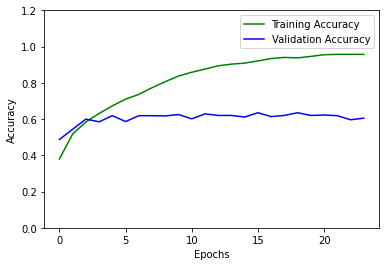

In [ ]:
def plot_learning_curves(history):
    print('')
    print('Curves..')
    # print(history.params)
    plt.clf()
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], 'g', label = 'Training Accuracy')
        plt.plot(history.history['val_accuracy'], 'b', label = 'Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
    else:
        plt.plot(history.history['mae'], 'g', label = 'Training MAE')
        plt.plot(history.history['val_mae'], 'b', label = 'Validation MAE')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
    
    plt.ylim(0, 1.2)
    plt.legend()
    plt.show()

plot_learning_curves(history)

In [ ]:
test_generator = ImageDataGenerator(data_path, test_list, class_labels, batch_size)
print('Test generator size:', len(test_generator))

Test generator size: 75


In [ ]:
y_test = []

for i in range(len(test_generator)):
    xx, yy = test_generator[i]
    for j in range(batch_size):
        class_label = class_labels[list(yy[j]).index(1)]
        y_test.append(class_label)


In [ ]:
model.load_weights(file_weights)
score, acc = model.evaluate(test_generator)

75/75 [==============================] - 2s 20ms/step - loss: 0.9949 - accuracy: 0.6258


In [ ]:
print('Test Score:', score)
print("Test Accuracy: {}%".format(acc * 100))

Test Score: 0.9512844681739807
Test Accuracy: 60.083335638046265%


In [ ]:
prediction = model.predict(test_generator)

In [ ]:
for index, item in enumerate(prediction):
    max_prob_index = np.argmax(item)
    predicted_class = class_labels[max_prob_index]

    print('True class:', y_test[index], '\tPredicted class:', predicted_class)

True class: neutral 	Predicted class: sad
True class: neutral 	Predicted class: neutral
True class: neutral 	Predicted class: angry
True class: neutral 	Predicted class: neutral
True class: neutral 	Predicted class: sad
True class: neutral 	Predicted class: neutral
True class: neutral 	Predicted class: neutral
True class: neutral 	Predicted class: neutral
True class: neutral 	Predicted class: happy
True class: neutral 	Predicted class: sad
True class: neutral 	Predicted class: neutral
True class: neutral 	Predicted class: neutral
True class: neutral 	Predicted class: angry
True class: neutral 	Predicted class: happy
True class: neutral 	Predicted class: neutral
True class: neutral 	Predicted class: neutral
True class: neutral 	Predicted class: neutral
True class: neutral 	Predicted class: neutral
True class: neutral 	Predicted class: neutral
True class: neutral 	Predicted class: neutral
True class: neutral 	Predicted class: neutral
True class: neutral 	Predicted class: sad
True class: 

In [ ]:
train_eval = model.evaluate(train_generator)

625/625 [==============================] - 20s 32ms/step - loss: 0.7717 - accuracy: 0.6877
